In [1]:
from plate_detection.blocks import YoloV3
import tensorflow as tf
from plate_detection.yolo.const import YOLO_LAYERS, NUM_CLASSES, DARKNET_LAYERS
from plate_detection.yolo.utils import load_yolo_weights, load_image_as_tf, get_bboxes, freeze_darknet_layers, get_original_bbox

2025-01-25 09:53:54.758427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737795234.796449  128423 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737795234.807566  128423 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 09:53:54.845045: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = YoloV3(num_classes=NUM_CLASSES)()
#model.summary()
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

2025-01-25 09:54:00.097776: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/malik/.cache/pypoetry/virtualenvs/license-plate-recognition-E7j_m8ey-py3.10/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'DarkNet_Conv2D_0', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/malik/.cache/pypoetry/virtualenvs/license-plate-recognition-E7j_m8ey-py3.10/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'DarkNet_Residual_1_Conv2D1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. Th

In [3]:
layers = load_yolo_weights("/home/malik/projects/license-plate-recognition/.weights/yolov3-custom_final.weights", model, YOLO_LAYERS)

Successfull data write


In [4]:
scale, image = load_image_as_tf("/home/malik/projects/license-plate-recognition/plate_detection/WhatsApp Image 2025-01-22 at 23.02.31_602827a9.jpg")

out = model(image)

In [5]:
detections = get_bboxes(out)
detections

(array([[ 56, 227, 119, 270]], dtype=int32),
 array([0], dtype=int32),
 array([0.9504604], dtype=float32))

In [8]:
oim = tf.image.decode_image(open("/home/malik/projects/license-plate-recognition/plate_detection/WhatsApp Image 2025-01-22 at 23.02.31_602827a9.jpg", 'rb').read(), channels=3)
oim.shape

TensorShape([1200, 1600, 3])

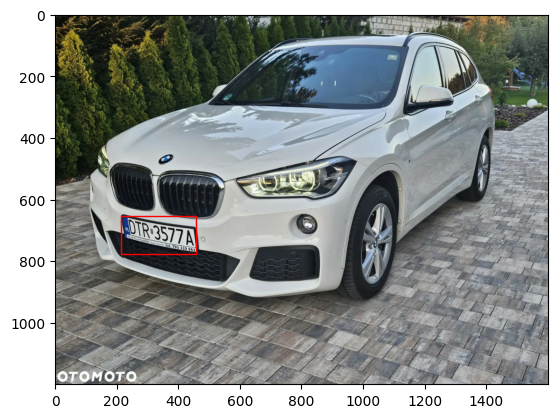

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


fig, ax = plt.subplots()

# Display the image
ax.imshow(oim)

boxes, _class, conf = detections
for box in boxes:
    # Get the bounding box coordinates
    
    x1, y1, x2, y2 = get_original_bbox(scale, box)

    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    # Add the rectangle to the Axes
    ax.add_patch(rect)

# # Show the plot with the rectangle
plt.show()

Training

In [4]:
load_yolo_weights("/home/malik/projects/license-plate-recognition/.weights/darknet53.conv.74", model, DARKNET_LAYERS)

Successfull data write


In [5]:
model = freeze_darknet_layers(model)

In [ ]:
import argparse

import tensorflow as tf
import numpy as np
from tqdm import tqdm
from plate_detection.blocks import YoloV3
from plate_detection.utils.utils import mean_average_precision
from plate_detection.yolo.const import (
    LEARNING_RATE,
    WEIGHT_DECAY,
    ANCHORS,
    ANCHORS_MASKS,
    SCALES,
    NUM_EPOCHS,
    NMS_IOU_THRESH,
    CONF_THRESHOLD,
    SAVE_MODEL,
    BATCH_SIZE,
)
from plate_detection.yolo.utils import (
    cell_to_bboxes, 
    get_evaluation_bboxes, 
    save_checkpoint, 
    load_checkpoint, 
    check_class_accuracy,
)
from plate_detection.yolo.loss import YoloLoss
from plate_detection.yolo.dataset import YoloDataset